## Create design matrix
First, get a list of the BOLD data (questionnaire average maps for every subject) and make sure it is ordered correctly. 

In [1]:
import glob
import re

questionnaire_avg_out = "/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/questionnaire_averages"
bold_files = glob.glob(f"{questionnaire_avg_out}/*")
sub_ids = sorted(set([re.search('_sub_(.*).nii.gz', val).group(1) for val in bold_files]))
print(sub_ids) # check that it's sorted correctly

questionnaires_list = ["grit", "brief", "future_time", "upps", "impulsive_venture"]
sorted_bold_files = []
for sub in sub_ids:
    for q in questionnaires_list:
        sorted_bold_files.append(f"{questionnaire_avg_out}/{q}_questionnaire_avg_sub_{sub}.nii.gz")
print("Number of BOLD files:", len(sorted_bold_files))


['130', '172', '192', '234', '465', '518', '519', '524', '526', '546', '548', '549', '553', '554', '555', '557', '558', '561', '567', '570', '572', '574', '577', '582', '583', '584', '585', '586', '587', '589', '590', '591', '592', '593', '594', '595', '596', '601', '602', '604', '606', '607', '608', '609', '611', '612', '613', '614', '616', '619', '621', '622', '626', '628', '629', '633', '636', '637', '638', '641', '642', '643', '645', '646', '647', '648']
Number of BOLD files: 330


Now, create the design matrix.

rank: 70
number of columns in design matrix: 70


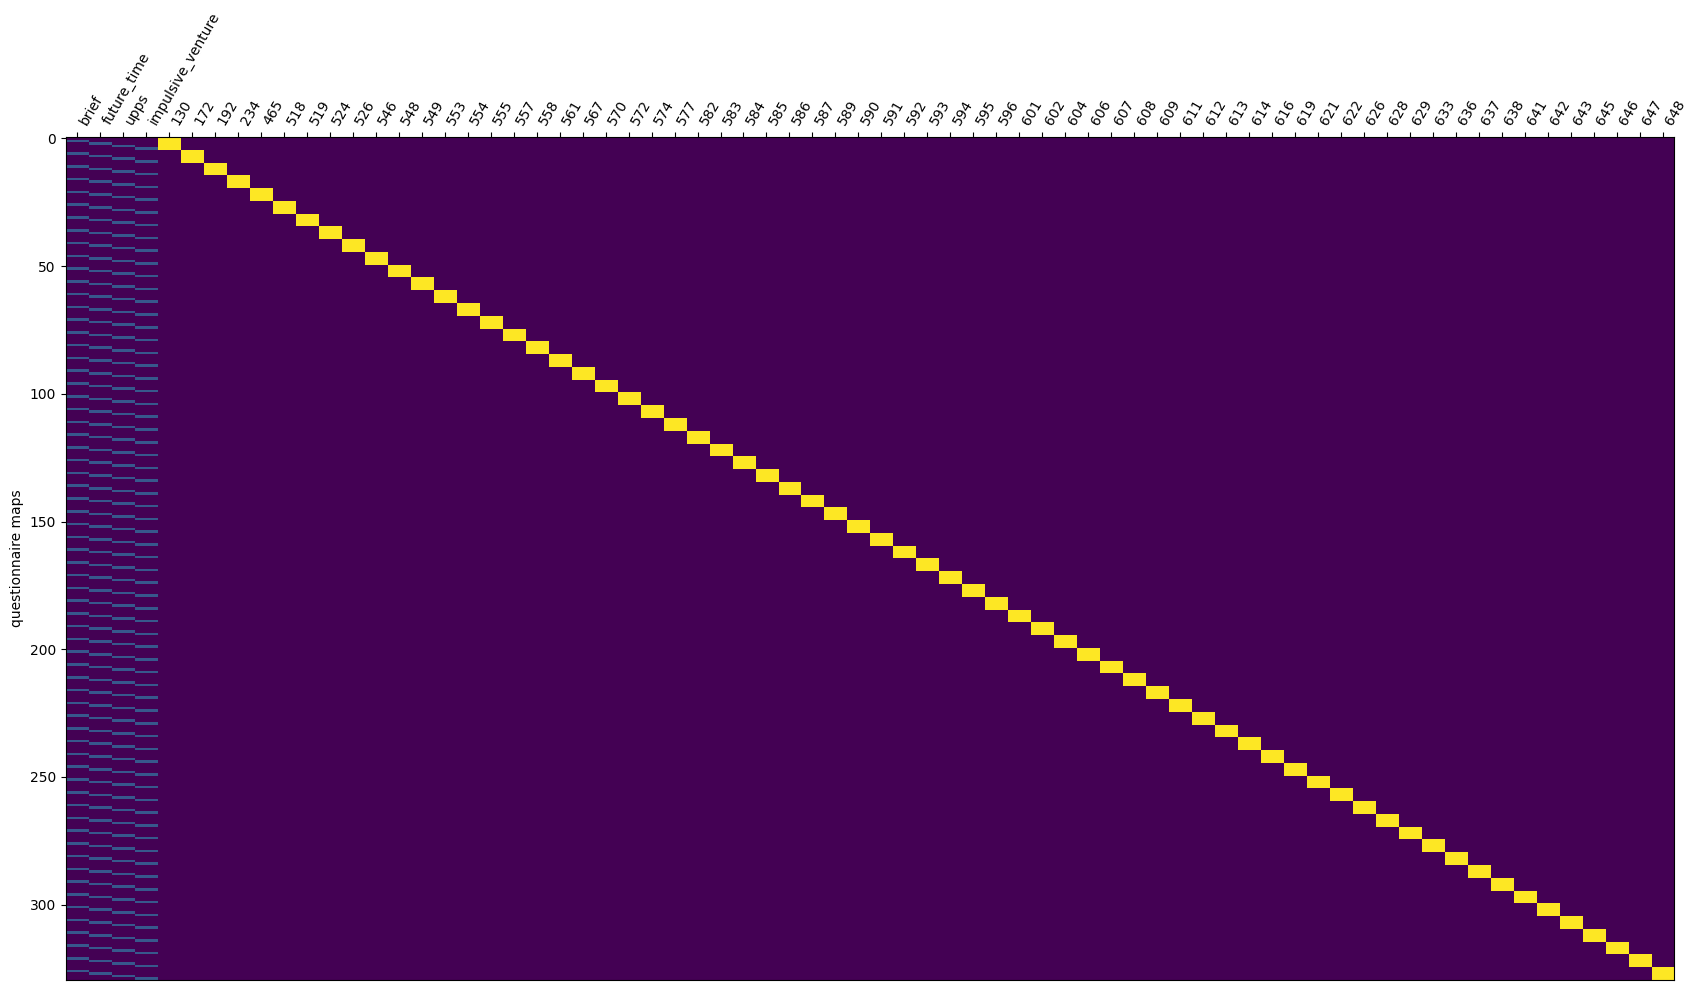

In [2]:
import pandas as pd
from nilearn.plotting import plot_design_matrix, plot_stat_map
import matplotlib.pyplot as plt
import numpy as np

design_matrix = pd.DataFrame()
# First 4 columns are dummy regressors for questionnaires 2-5 (brief, future_time, upps, and impulsive_venture)
one_indices = []
for i in range(len(sub_ids)):
    one_indices.append(1 + len(questionnaires_list) * i)
for i in range(len(questionnaires_list) - 1):
    one_indices_updated = [x + i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[questionnaires_list[i + 1]] = col
# The other 66 columns are dummy regressors for each subject
one_indices = [0, 1, 2, 3, 4]
for i in range(len(sub_ids)):
    one_indices_updated = [x + len(questionnaires_list) * i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[sub_ids[i]] = col

rank = np.linalg.matrix_rank(design_matrix.values)
num_columns = len(design_matrix.columns)
print("rank:", rank)
print("number of columns in design matrix:", num_columns)

design_matrix_plot = plot_design_matrix(design_matrix)
design_matrix_plot.set_ylabel("questionnaire maps")
plt.show()



## Create contrast

In [3]:
contrast = np.zeros((4, 70)) 
contrast[:, 0:4] = np.eye(4)
print(contrast)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Specify and run second level model

In [4]:
from nilearn.glm.second_level import SecondLevelModel
import nibabel as nf

model = SecondLevelModel(n_jobs=2)
model.fit(sorted_bold_files, design_matrix=design_matrix)
f_stat_map = model.compute_contrast(second_level_contrast=contrast, second_level_stat_type='F', output_type='stat')
nf.save(f_stat_map, 'questionnaire_averages_f_test_f_stat.nii.gz')

z_map = model.compute_contrast(second_level_contrast=contrast, second_level_stat_type='F', output_type='z_score')
nf.save(z_map, 'questionnaire_averages_f_test_z_score.nii.gz')

# Get clusters from F-statistic maps

In [5]:
from scipy.stats import f

# Degrees of freedom
df_num = contrast.shape[0]
df_den = design_matrix.shape[0] - design_matrix.shape[1]

# F thresholds for p = 0.05 and p = 0.0005 (right-tail)
f_p_05 = f.isf(0.05, df_num, df_den)
f_p_0005 = f.isf(0.0005, df_num, df_den)

Get the cluster tables for both thresholds (p < 0.05 and p < 0.0005)

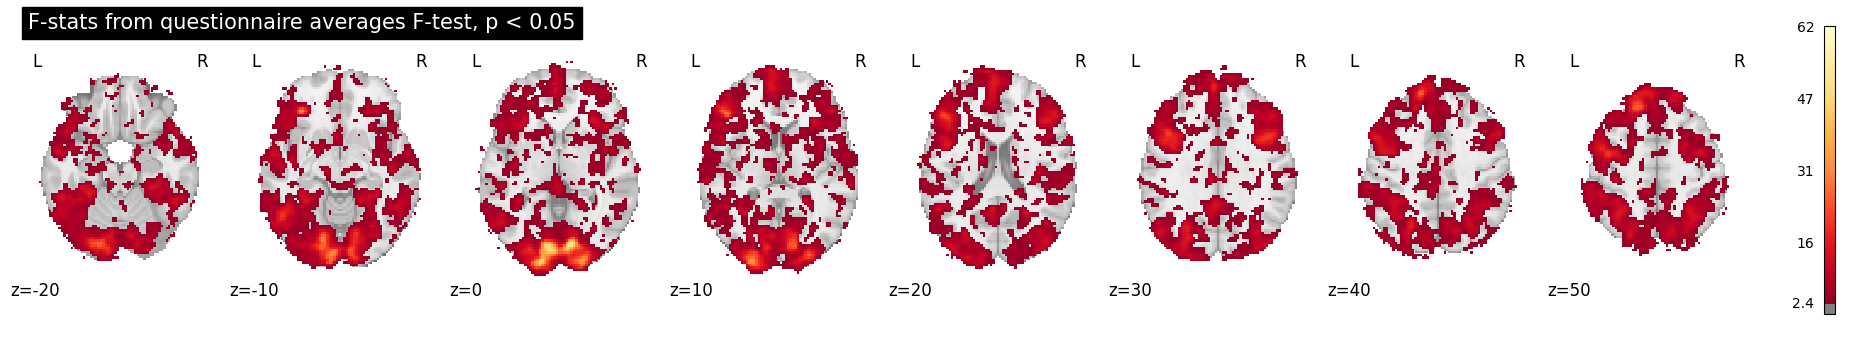

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Cluster Size (vox)
0,1,-6.299998,-90.699999,-3.699998,62.181972,839616,78852
1,2,-39.299999,-26.899998,53.500003,10.444821,8273,777
2,3,33.300003,-46.699998,22.700002,7.540097,521,49
3,4,-4.099998,-37.899998,-27.899999,6.473808,1618,152
4,5,35.500003,-2.699997,-41.099999,5.850990,1267,119
...,...,...,...,...,...,...,...
815,816,-1.899998,-31.299998,-56.500000,2.408774,10,1
816,817,-30.499999,-44.499998,-30.099999,2.408622,10,1
817,818,39.900003,19.300003,-41.099999,2.408155,10,1
818,819,46.500003,-68.699999,55.700003,2.407797,10,1


In [16]:
from nilearn.reporting import get_clusters_table

z_slices = [-20, -10, 0, 10, 20, 30, 40, 50]
plot_stat_map(f_stat_map,
                display_mode='z',
                cut_coords=z_slices,
                threshold=f_p_05,
                colorbar=True,
                cmap='YlOrRd_r', 
                title=f'F-stats from questionnaire averages F-test, p < 0.05'
            )
plt.show()

cluster_table_p_05 = get_clusters_table(
    stat_img=f_stat_map,
    stat_threshold=f_p_05,   # F-stat threshold
    cluster_threshold=0,     # min cluster size in voxels (set >0 to filter)
    two_sided=False,            # F-tests are always positive
    min_distance=500
)
cluster_table_p_05['Cluster Size (mm3)'] = pd.to_numeric(cluster_table_p_05['Cluster Size (mm3)'])
cluster_table_p_05['Cluster Size (vox)'] = np.round(cluster_table_p_05['Cluster Size (mm3)'] / 10.648).astype(int)
pd.reset_option('display.max_rows')
cluster_table_p_05

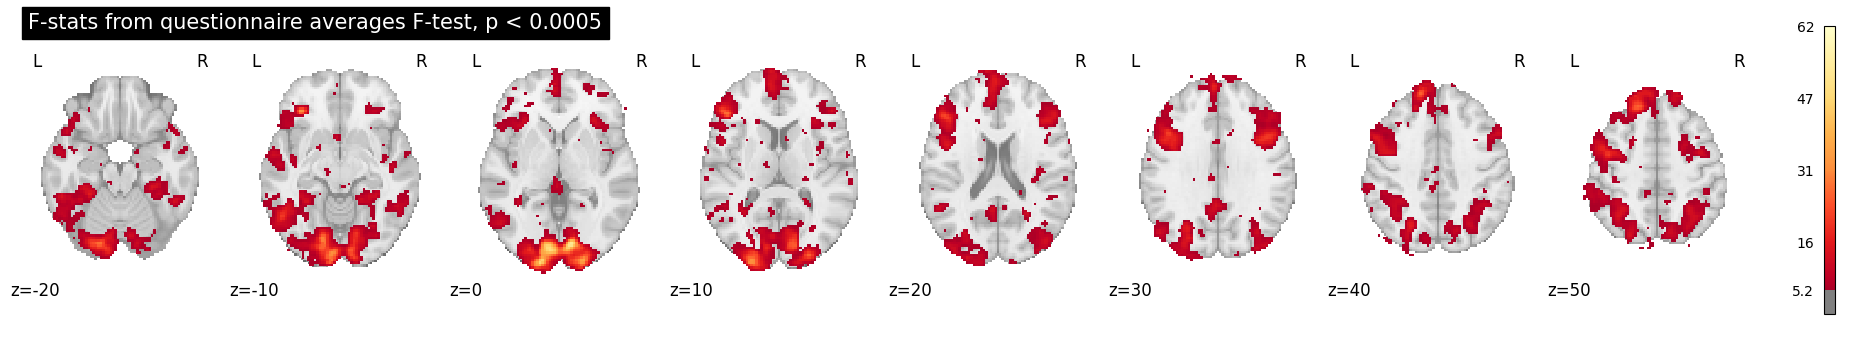

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Cluster Size (vox)
0,1,-6.299998,-90.699999,-3.699998,62.181972,159922,15019
1,2,-34.899999,34.700004,-10.299999,33.475270,47979,4506
2,3,-17.299998,39.100004,51.300003,27.047872,37172,3491
3,4,46.500003,10.500003,31.500002,20.841655,16397,1540
4,5,31.100003,25.900003,-3.699998,16.479218,3215,302
5,6,-32.699999,-55.499998,7.300002,16.329500,1373,129
6,7,2.500002,-31.299998,-3.699998,15.535772,1064,100
7,8,26.700003,-40.099998,-12.499999,14.170489,8805,827
8,9,37.700003,-2.699997,46.900003,12.939243,4695,441
9,10,-52.499999,-75.299999,29.300002,12.063001,2363,222


In [17]:
plot_stat_map(f_stat_map,
                display_mode='z',
                cut_coords=z_slices,
                threshold=f_p_0005,
                colorbar=True,
                cmap='YlOrRd_r', 
                title=f'F-stats from questionnaire averages F-test, p < 0.0005'
            )
plt.show()

cluster_table_p_0005 = get_clusters_table(
    stat_img=f_stat_map,
    stat_threshold=f_p_0005,   # F-stat threshold
    cluster_threshold=0,     # min cluster size in voxels (set >0 to filter)
    two_sided=False,            # F-tests are always positive
    min_distance=500
)
cluster_table_p_0005['Cluster Size (mm3)'] = pd.to_numeric(cluster_table_p_0005['Cluster Size (mm3)'])
cluster_table_p_0005['Cluster Size (vox)'] = np.round(cluster_table_p_0005['Cluster Size (mm3)'] / 10.648).astype(int)
pd.set_option('display.max_rows', None)
cluster_table_p_0005